In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model,  load_model
from keras.optimizers import SGD

import numpy as np

%matplotlib inline

## Set up Architecture

In [56]:
from keras import regularizers

#set up the architecture with VGG
#Import the weights for VGG16
model_vgg_conv = VGG16(weights='imagenet', include_top=False)

#input format
inp = Input(shape=(224,224,3),name = 'image_input')

# set the convolutional layers to non-trainable
for layer in model_vgg_conv.layers:
    layer.trainable=False

output_vgg_conv = model_vgg_conv(inp)
    
#Add Dense layers 
x = Flatten(name='flatten')(output_vgg_conv)
## Original structure
#x = Dense(4096, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)

## New weights for a simpler problem
x = Dense(512, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(3, activation='softmax', name='predictions')(x) #output layer

#compile into one model
model = Model(inputs=inp, outputs=x)
model.summary()
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               12845568  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size=16

#build generators for train/test/validation images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=30,
        zoom_range=0.2,
        horizontal_flip=True)

# augmentation configuration we will use for testing
test_datagen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.2,
    rotation_range=15,
    horizontal_flip=True)

# generator that reads pictures from train directory
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=True)

In [ ]:
# Train the moodel

model.fit_generator(
        train_generator,
        steps_per_epoch=1800 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=450 // batch_size)

model.save('model.h5')

## Evaluate model performance

In [ ]:
#Evaluate accuracy and loss function on train, validation and test

train_results = model.evaluate_generator(train_generator, steps=400)
val_results = model.evaluate_generator(validation_generator, steps=400)
test_results = model.evaluate_generator(test_generator, steps=400)

print('train:',list(zip(model.metrics_names, train_results)))
print('validation:',list(zip(model.metrics_names, val_results)))
print('test:',list(zip(model.metrics_names, test_results)))

### Building a Confusion Matrix

In [74]:
n = 600

x = []
y_true = []
labels =  list(test_generator.class_indices.keys())

for i in range(n):
    x1, y1 = next(test_generator)
    x.append(x1)
    y_true.append(y1.tolist()[0].index(1.)+1)

y_pred = []

for i in x:
    y_pred.append(model.predict(i).argmax()+1)

Normalized confusion matrix
[[ 0.85436893  0.05789474  0.06862745]
 [ 0.0776699   0.77368421  0.14215686]
 [ 0.06796117  0.16842105  0.78921569]]


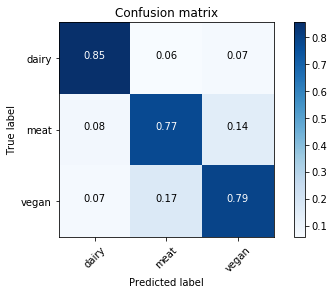

In [75]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          norm_axis='Precision',
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        if norm_axis == 'Precision':
            cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]
        elif norm_axis =='Recall':
            cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plot_confusion_matrix(confusion_matrix(y_true, y_pred), labels)
